In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
import keras
 
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential,  load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
 
# from keras import regularizers
from keras.layers import SimpleRNN, Input, Dense, LSTM, Embedding, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.layers.merge import add
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from nltk.translate.bleu_score import corpus_bleu
 
# Helper libraries
import numpy as np
from numpy import array, argmax
 
import pandas as pd
import time
import random
import string
import os
import os.path
from os import listdir
import cv2 as cv
 
# import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
 
# Pickle
import pickle
from pickle import dump, load
 
print(tf.__version__)
print('keras: %s' % keras.__version__)

2.6.0
keras: 2.6.0


In [ ]:
#Overall Program Execution Time
program_start_time = time.time()

In [ ]:
# verify GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Sep 19 15:24:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |    220MiB / 15109MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
 
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FILEPATH = "/content/drive/MyDrive/Colab Notebooks/dl_assignment2_data/"
VERSION = "v2.2"

In [ ]:
images_folder=FILEPATH+"Flicker8k_Dataset"
files=os.listdir(images_folder)
print("Total Image Files Found:",len(files))

Total Image Files Found: 8091


In [ ]:
# load : get the data from file
captions_picklefile= FILEPATH+'set_0.pkl'
captions = pickle.load(open(captions_picklefile, "rb"))
print("Total Image Captions Found:",len(captions))

Total Image Captions Found: 25000


## 2. Data Visualization and augmentation
### 2.a Preprocessing Captions
- Pickle	file	contains	the	image	id	and	the	text	associated	with	the	image.
- Eg:	'319847657_2c40e14113.jpg#0\tA	girl	in	a	purple	shirt	hold	a	pillow .
- Each	image	can	have	multiple	captions.
- 319847657_2c40e14113.jpg	->	image	name
- "#0"	->	Caption	ID
- \t ->	separator	between	Image	name and	Image	Caption
- A	girl	in	a	purple	shirt	hold	a	pillow	. ->	Image	Caption
- We clean the text in the following ways in order to reduce the size of the vocabulary of words:
> - Convert all words to lowercase
> - Remove all punctuation.
> - Remove all words that are one character or less in length (e.g. ‘a’).
> - Remove all words with numbers in them.




In [ ]:
# extract descriptions for images
def load_descriptions(data):
	mapping = dict()
	# process lines
	for line in data:
		# split line by "\t" space
		tokens = line.split("\t")
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping
 
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)
 
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc
 
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

fname = FILEPATH+'captions.txt'
descriptions = load_descriptions(captions)
# clean descriptions
print("Cleaning Captions")
clean_descriptions(descriptions)

# save to file
print("Saving cleaned up captions to captions.txt")
save_descriptions(descriptions, fname)
print(fname, " saved successfully!")

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)

print('Total Distinct Images Caption Loaded: %d ' % len(descriptions))
print("4 Image along with Captions", list(descriptions.items())[:4])
print('Caption vocabulary size: %d' % len(vocabulary))

Cleaning Captions
Saving cleaned up captions to captions.txt
/content/drive/MyDrive/Colab Notebooks/dl_assignment2_data/captions.txt  saved successfully!
Total Distinct Images Caption Loaded: 8037 
4 Image along with Captions [('318667317_108c402140', ['man in black hoodie be hold paper sign', 'homeless man carry sign that say hungry', 'bearded man hold sign', 'man in black hoodie hold small sign']), ('2072574835_febf0c5fb9', ['three race dog be run out of the start gate on track', 'greyhound dog wear race stripe be run out of gate on track', 'dog in race']), ('3083016677_5782bc337c', ['two motorcycle with two rider each', 'there be two motorcycle with man and woman on it', 'two guy with helmet be on motorcycle each with woman ride behind him', 'two motorcycle and four rider be on road']), ('95734038_2ab5783da7', ['man on bike nest to river', 'man ride bicycle on rocky path beside lake in the mountain', 'man stand astride bike on rocky trail by lake'])]
Caption vocabulary size: 5490


### 2.b Plot at least two samples and their captions (use matplotlib/seaborn/any other library).

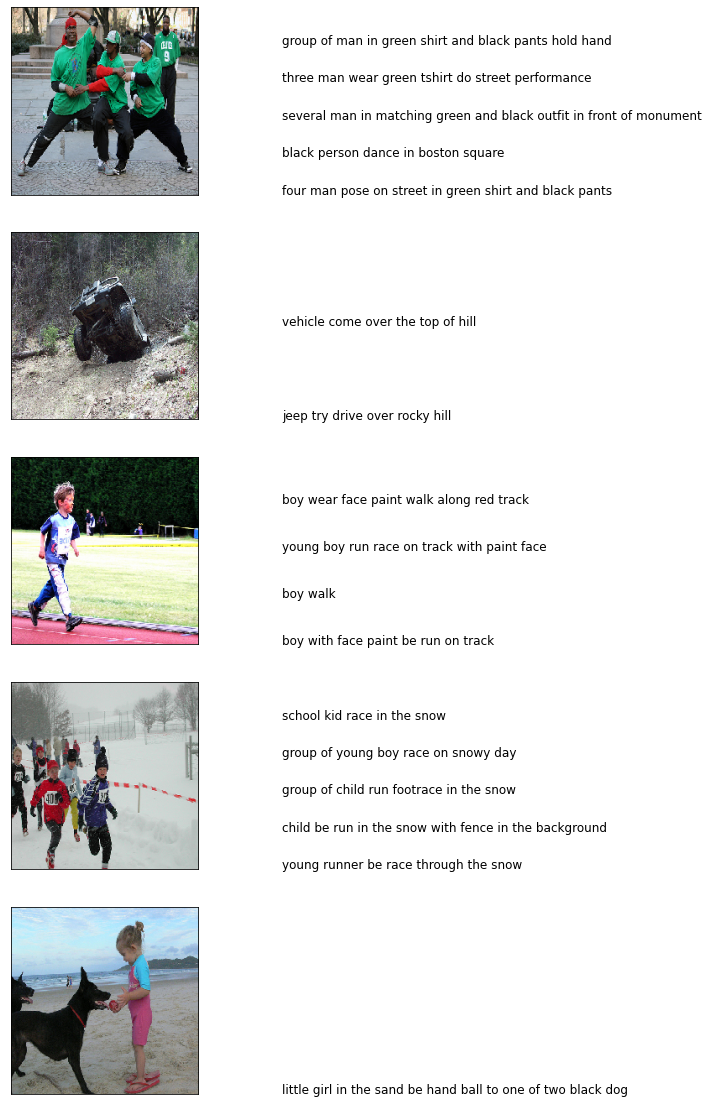

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in files[:npic]:
  filename = images_folder + '/' + jpgfnm
  image_id = jpgfnm.split('.')[0]
  captions = descriptions.get(image_id)
  image_load = load_img(filename, target_size=target_size)

  ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
  ax.imshow(image_load)
  count += 1

  ax = fig.add_subplot(npic,2,count)
  plt.axis('off')
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(captions))
  for i, caption in enumerate(captions):
      ax.text(0,i,caption,fontsize=12)
  count += 1
plt.show()

# for i in range(2):
#   # load sample images
#   img_file = images_folder+"/"+files[i]
#   image_id = files[i].split('.')[0]
#   caption = descriptions.get(image_id)

#   plt.figure()
#   img = cv.imread(img_file)
#   plt.imshow(img) 
#   plt.title(files[i])
#   plt.figtext(0.01, 0.01, caption, wrap=True, horizontalalignment='left', fontsize=12)
#   plt.show()  # display it

### 2.c Bring the train and test data in the required format

In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions
 
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# calculate the length of the description with the most words
def desc_max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
 
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)
 
 
# train dataset
features_key = load(open(FILEPATH+'features.pkl', 'rb')) 

# load training dataset (6K)
# matching descriptions keys against features key and only take that forward for training
intersection = [i for i in descriptions.keys() if i in features_key]
print("Total Dataset where image and captions are matching:", len(intersection)) 
# load training dataset (6K)
train = random.sample(intersection,6000)
# descriptions
train_descriptions = load_clean_descriptions(FILEPATH+'captions.txt', train)
print('Captions: train=%d' % len(train_descriptions))

# photo features
train_features = load_photo_features(FILEPATH+'features.pkl', train)
print('Photos: train=%d' % len(train_features))

tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# determine the maximum sequence length
maxlength = desc_max_length(train_descriptions)
print('Description Max Length: %d' % maxlength)

# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, maxlength, train_descriptions, train_features, vocab_size)

tokenizer_filename = FILEPATH+'tokenizer.pkl'
print("Dumping train tokeniser for future reference, " , tokenizer_filename)
dump(tokenizer, open(tokenizer_filename, 'wb'))

Total Dataset where image and captions are matching: 8036
Captions: train=6000
Photos: train=6000
Vocabulary Size: 4812
Description Max Length: 31
Dumping train tokeniser for future reference,  /content/drive/MyDrive/Colab Notebooks/dl_assignment2_data/tokenizer.pkl


In [ ]:
# test dataset

# load test set 1000 records
remaining_intersection = [i for i in intersection + train if i not in intersection or i not in train]
test = random.sample(remaining_intersection,1000)

# descriptions
test_descriptions = load_clean_descriptions(FILEPATH+'captions.txt', test)
print('Captions: test=%d' % len(test_descriptions))

# photo features
test_features = load_photo_features(FILEPATH+'features.pkl', test)
print('Photos: test=%d' % len(test_features))

# prepare tokenizer
# tokenizer = create_tokenizer(test_descriptions)
# test_vocab_size = len(tokenizer.word_index) + 1
# print('Vocabulary Size: %d' % test_vocab_size)

# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, maxlength, test_descriptions, test_features, vocab_size)

# tokenizer_filename = FILEPATH+'test_tokenizer.pkl'
# print("Dumping test tokeniser for future reference, " , tokenizer_filename)
# dump(tokenizer, open(tokenizer_filename, 'wb'))

Captions: test=1000
Photos: test=1000


## 3. Model Building

The model is in three parts:
- Photo Feature Extractor: This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.
- Sequence Processor: This is a word embedding layer for handling the text input, followed by a recurrent neural network layer as per assignment ask.
- Decoder: Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction. The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo.

The Sequence Processor model expects input sequences with a pre-defined length (34 words) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an RNN layer as per assignment ask

Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast. 

**Other configuration and its impact has been summarised in Findings section towards the end of file**.

The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

### 3.a Use Pretrained VGG-16 model trained on ImageNet dataset (available publicly on google) for image feature extraction

In [ ]:
# extract features from each photo in the directory using VGG-16 pre-trained model
def extract_features(directory):
  # load the model
  model = VGG16()
  # re-structure the model
  model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
  # summarize
  print(model.summary())
  # extract features from each photo
  features = dict()
  count = 0
  captions_key = list(descriptions.keys())
  for name in listdir(directory):
    # get image id
    image_id = name.split('.')[0]

    if(image_id in captions_key):
      count += 1
      # load an image from file
      filename = directory + '/' + name
      image = load_img(filename, target_size=(224, 224))
      # convert the image pixels to a numpy array
      image = img_to_array(image)
      # reshape data for the model
      image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
      # prepare the image for the VGG model
      image = preprocess_input(image)
      # get features
      feature = model.predict(image, verbose=0)
      # store feature
      features[image_id] = feature
      if(count % 500 == 0):
        print("> Processed ", count)
    else:
      print("> Skipping file as missing caption ", name)
  return features

fname = FILEPATH+'features.pkl'
if os.path.isfile(fname):
  print(fname, " already exists!")
  features = pickle.load(open(fname, "rb"))
else:
  # extract features from all images
  features = extract_features(images_folder)
  # save to file
  dump(features, open(fname, 'wb'))
  print(fname, " saved successfully!")

print('Features : %d' % len(features))

/content/drive/MyDrive/Colab Notebooks/dl_assignment2_data/features.pkl  already exists!
Features : 8036


(repeat from previous section)
The model is in three parts:
- Photo Feature Extractor: This is a 16-layer VGG model pre-trained on the ImageNet dataset. We have pre-processed the photos with the VGG model (without the output layer) and will use the extracted features predicted by this model as input.
- Sequence Processor: This is a word embedding layer for handling the text input, followed by recurrent neural network layer as per assignment ask
- Decoder: Both the feature extractor and sequence processor output a fixed-length vector. These are merged together and processed by a Dense layer to make a final prediction. The Photo Feature Extractor model expects input photo features to be a vector of 4,096 elements. These are processed by a Dense layer to produce a 256 element representation of the photo.

The Sequence Processor model expects input sequences with a pre-defined length (31) which are fed into an Embedding layer that uses a mask to ignore padded values. This is followed by an RNN layer as per the assignment ask.

Both the input models produce a 256 element vector. Further, both input models use regularization in the form of 50% dropout. This is to reduce overfitting the training dataset, as this model configuration learns very fast.

**Other configuration and its impact has been summarised in Findings section towards the end of file**.

The Decoder model merges the vectors from both input models using an addition operation. This is then fed to a Dense 256 neuron layer and then to a final output Dense layer that makes a softmax prediction over the entire output vocabulary for the next word in the sequence.

### 3.b Create 3 layered RNN layer model and other relevant layers for image caption generation
### 3.c Add L2 regularization to all the RNN layers.
### 3.d Add one layer of dropout at the appropriate position and give reasons
We added drop out after the Simple RNN Stack, the difference in accuracy and overfitting not much, but as this gave better BLEU-4 score and better generated caption we went wit this 
### 3.e Choose the appropriate activation function for all the layers.
For Simple RNN, we used RELU as default activation function
### 3.f Print the model summary.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 31, 128)      615936      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 31, 128)      0           embedding[0][0]                  
__________________________________________________________________________________________________
simple_rnn (SimpleRNN)          (None, 31, 128)      32896       dropout_1[0][0]                  
______________________________________________________________________________________________

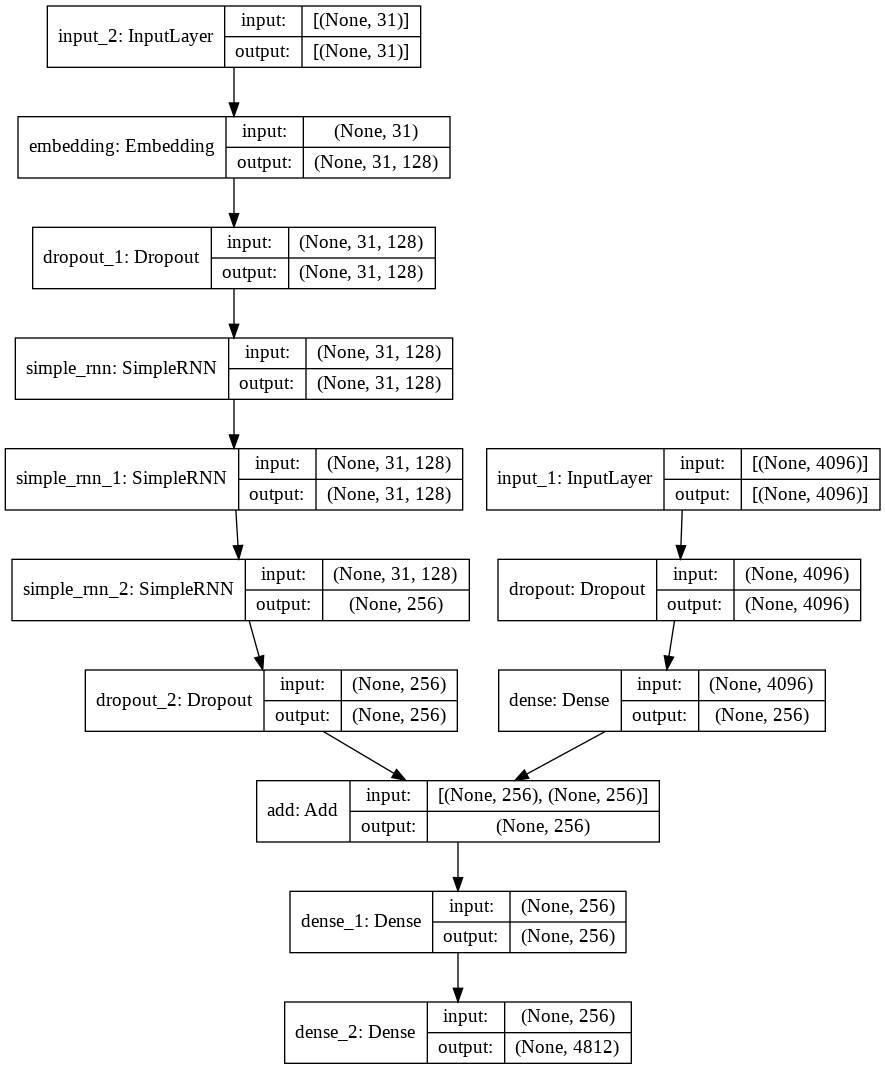

In [ ]:
# feature extractor model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
 
# sequence model
inputs2 = Input(shape=(maxlength,))
#se1 = Embedding(vocab_size, 128, mask_zero=True)(inputs2)
se1 = Embedding(vocab_size, 128)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = SimpleRNN(128, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(se2)
se4 = SimpleRNN(128, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(se3)
se5 = SimpleRNN(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(se4)
se6 = Dropout(0.2)(se5)

# decoder model
decoder1 = add([fe2, se6])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
 
# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
 
# summarize model
print(model.summary())
plot_model(model, to_file=FILEPATH+'model.png', show_shapes=True)

## 4. Model Compilation
### 4.a. Compile the model with the appropriate loss function.
### 4.b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.
We used Adam as Optimiser with (learning_rate=0.0001, decay=1e-6), the reason was we got better accuracy with the learning rate. So we kept this constant for model parameters exploration

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ["accuracy"])

## 5. Model Training
### 5.a. Train the model for an appropriate number of epochs. Print the train and validation loss for each epoch. Use the appropriate batch size.

In [ ]:
#to store start tme to compute model training time 
modelfit_time = time.time()

In [ ]:
model_filepath = FILEPATH + 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(model_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# patient early stopping
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# fit model
history = model.fit([X1train, X2train], ytrain, epochs=20, verbose=1, callbacks=[checkpoint, earlystop], validation_data=([X1test, X2test], ytest))

Epoch 1/20
5894/5894 [==============================] - 418s 70ms/step - loss: 5.2102 - accuracy: 0.1467 - val_loss: 4.6813 - val_accuracy: 0.1822

Epoch 00001: val_loss improved from inf to 4.68131, saving model to /content/drive/MyDrive/Colab Notebooks/dl_assignment2_data/model-ep001-loss5.210-val_loss4.681.h5
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


5894/5894 [==============================] - 404s 69ms/step - loss: 4.4237 - accuracy: 0.2020 - val_loss: 4.2868 - val_accuracy: 0.2245

Epoch 00002: val_loss improved from 4.68131 to 4.28680, saving model to /content/drive/MyDrive/Colab Notebooks/dl_assignment2_data/model-ep002-loss4.424-val_loss4.287.h5
Epoch 3/20
5894/5894 [==============================] - 404s 69ms/step - loss: 4.0104 - accuracy: 0.2349 - val_loss: 4.1389 - val_accuracy: 0.2397

Epoch 00003: val_loss improved from 4.28680 to 4.13895, saving model to /content/drive/MyDrive/Colab Notebooks/dl_assignment2_data/model-ep003-loss4.010-val_loss4.139.h5
Epoch 4/20
5894/5894 [==============================] - 401s 68ms/step - loss: 3.7767 - accuracy: 0.2491 - val_loss: 4.1249 - val_accuracy: 0.2437

Epoch 00004: val_loss improved from 4.13895 to 4.12491, saving model to /content/drive/MyDrive/Colab Notebooks/dl_assignment2_data/model-ep004-loss3.777-val_loss4.125.h5
Epoch 5/20
5894/5894 [==============================] - 4

### 5.b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [ ]:
secs = time.time() - modelfit_time
mins = secs / 60
print("MOdel Training took %s seconds ---" % "{:.2f}".format(secs))
print("MOdel Training took %s mins ---" % "{:.2f}".format(mins))

MOdel Training took 3638.16 seconds ---
MOdel Training took 60.64 mins ---


In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


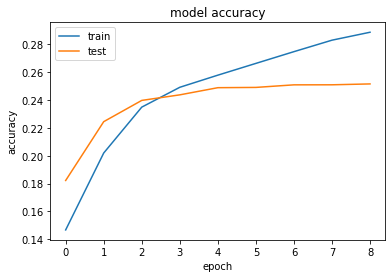

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

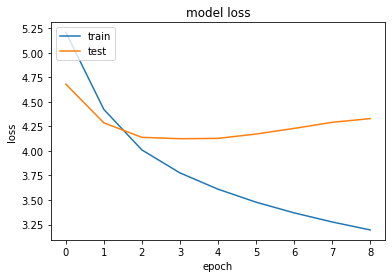

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 6. Model Evaluation
### 6.a. Take a random image from google and generate caption for that image.

In [ ]:
# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [ ]:
# Optional State, to use previously generated Model Fit File, in case machine crashes, change the file name 
model_file = "model-ep005-loss3.679-val_loss4.294.h5"
try:
    model
except NameError:
   # this is only to be used if we are retoring the file
    model_filename = FILEPATH+model_file
    print("Model not found loading from saved file! ", model_filename)
    model = load_model(model_filename)

    tokenizer_filename = FILEPATH+'tokenizer.pkl'
    print("Loading tokeniser, " , tokenizer_filename)
    tokenizer = load(open(tokenizer_filename, 'rb')) 
    
    maxlength = 31
else:
    print("Ah model is found, using the same evaluation!")

Ah model is found, using the same evaluation!


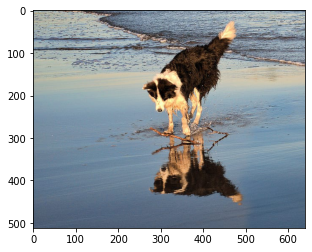

startseq dog run in the water endseq


In [ ]:
# load and prepare the photograph
img_file = FILEPATH+'test_image1.jpg'
# plt.figure()
# img = cv.imread(img_file)
# plt.imshow(img) 
# plt.show()  # display it

img = mpimg.imread(img_file)
imgplot = plt.imshow(img)
plt.show()

# generate description
photo = extract_features(img_file)
print(generate_desc(model, tokenizer, photo, maxlength))

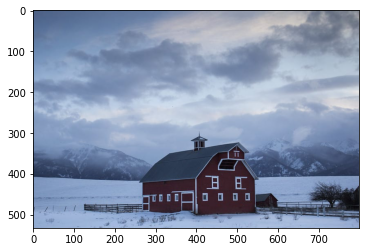

startseq person be stand on the snow endseq


In [ ]:
# load and prepare the photograph
img_file = FILEPATH+'test_image2.jpg'
# plt.figure()
# img = cv.imread(img_file)
# plt.imshow(img) 
# plt.show()  # display it

img = mpimg.imread(img_file)
imgplot = plt.imshow(img)
plt.show()

# generate description
photo = extract_features(img_file)
print(generate_desc(model, tokenizer, photo, maxlength))

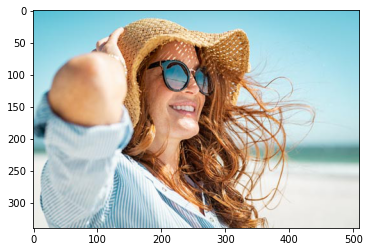

startseq woman in pink shirt be her her endseq


In [ ]:
# load and prepare the photograph
img_file = FILEPATH+'test_image6.jpg'
# plt.figure()
# img = cv.imread(img_file)
# plt.imshow(img) 
# plt.show()  # display it

img = mpimg.imread(img_file)
imgplot = plt.imshow(img)
plt.show()

# generate description
photo = extract_features(img_file)
print(generate_desc(model, tokenizer, photo, maxlength))

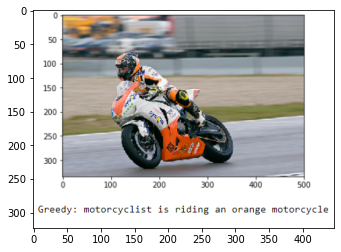

startseq motorcyclist in red jumpsuit be on racetrack endseq


In [ ]:
# load and prepare the photograph
img_file = FILEPATH+'test_image3.png'
# plt.figure()
# img = cv.imread(img_file)
# plt.imshow(img) 
# plt.show()  # display it

img = mpimg.imread(img_file)
imgplot = plt.imshow(img)
plt.show()

# generate description
photo = extract_features(img_file)
print(generate_desc(model, tokenizer, photo, maxlength))

In [ ]:
secs = time.time() - program_start_time
mins = secs / 60
print("Overall time took %s seconds ---" % "{:.2f}".format(secs))
print("Overall time took %s mins ---" % "{:.2f}".format(mins))

Overall time took 3743.39 seconds ---
Overall time took 62.39 mins ---


## Appendix 
### Model Evaluation

In [ ]:
start_time = time.time()

In [ ]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))  
 
# load the model
#filename = 'model-ep003-loss3.544-val_loss3.775.h5'
try:
    model
except NameError:
    model_filename = FILEPATH+'model-ep003-loss3.544-val_loss3.775.h5'
    print("Model not found loading from saved file! ", model_filename)
    model = load_model(model_filename)
else:
    print("Ah model is found, using the same evaluation!")

# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, maxlength)

Ah model is found, using the same evaluation!
BLEU-1: 0.558575
BLEU-2: 0.327969
BLEU-3: 0.232344
BLEU-4: 0.121410


In [ ]:
print("Model Evaluation took %s seconds ---" % "{:.2f}".format(time.time() - start_time))

Model Evaluation took 331.12 seconds ---


### Storing Hisotry, Train and Test Data for reference

In [ ]:
start_time = time.time()

In [ ]:
hist_file = FILEPATH + 'model-history'  + VERSION
dump(history.history, open(hist_file, 'wb'))

fname = FILEPATH + 'model-train-data' + VERSION 
dump([X1train, X2train, ytrain], open(fname, 'wb'))
fname = FILEPATH + 'model-test-data' + VERSION
dump([X1test, X2test, ytest], open(fname, 'wb'))

In [ ]:
print("Storing refenrece data took %s seconds ---" % "{:.2f}".format(time.time() - start_time))

Storing refenrece data took 78.21 seconds ---


## Final Summary

- In the model we found that adding Dropout post first Simple RNN gave better generated caption quality, and Training accuracy but compared to having drop out post Simple RNN Stack, is also comparable but gave better BLEU-4 score. This may be due to fact that we have added L2 Regularisation in each Simple RNN Layer which is preventing overfitting
- Next parameter we explored is L2 Regularisation, L2 with 0.001 gave slightly better performance as compared to 0.01 in terms of accuracy, BLEU Score and generated caption quality
- In terms of Optimiser we have used Adam(learning_rate=0.0001, decay=1e-6), with loss function categorical_crossentropy
- The second parameter we tried was by change the number of output of Simple RNN (128,128,128) vs (128,126,256), the different is former requires less number of parameters to train, however the memory / GPU requirements do not change drastically it is in range of 12GB ~ 16GB, which GPU around 8GB. 
- We also computed the BLEU scores to evaluate the quality of caption generated, they are comparable with the choosen model. 
- Finally the quality of caption generated, are much better for the selected model, however there seems to me more training / tuning required to get perfect captions, but we are limited by time and machine capacity to have higher epochs and GPU. 
- The biggest learning during the assignment is to have capability of restart by storing milestones objects, and reuse them to avoid taxing the resources. Image Feature extraction using VCG-16 is performed once and stored for re-use,  model fit has configuration to store the best model and stop early with patience of N (5~10) epochs.

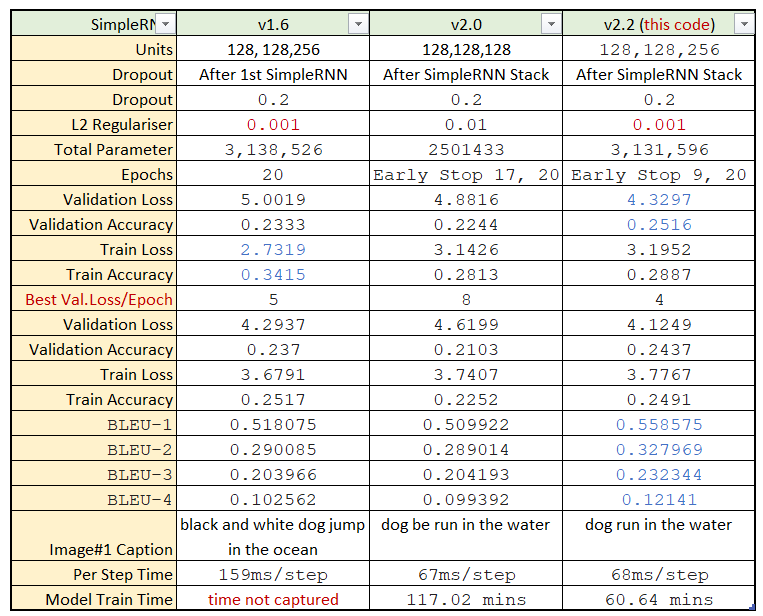

### Colab Memory Snapshot
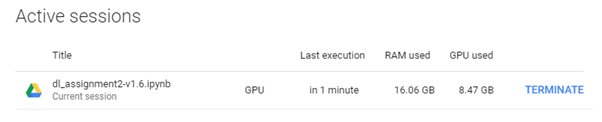

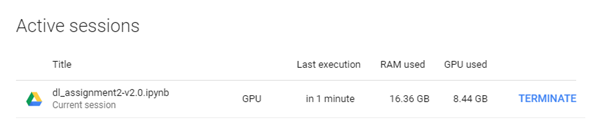

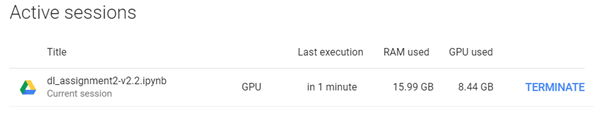